# A5

In [22]:
# Standard Imports
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import Network as NN
import importlib
import mnist_loader

import copy
import random

# Q1: Electrophysiology Experiment

In [23]:
import lif

def MonkeyFixationSpikes(x, T, pop):
    """
    spike_times = MonkeyFixationSpikes(x, T, pop)

    Given the gaze direction, outputs the spiking activity of the monkey's
    neurons.

    Input:
      x is the monkey's gaze direction https://www.student.cs.uwaterloo.ca/~cs343/
      T is the duration of the fixation (in seconds)
      pop is a 6xN matrix of LIF parameters

    Output:
      spike_times is an list containing N arrays of time-stamps indicating
        when each neuron fired.  
    """
    dt = 0.001  # time-step size for simulations
    xts = x*np.ones(int(T/dt))
    sp, v = lif.Stim2Spikes(xts, dt, pop, interp=True)
    return sp

In [24]:
#=====================
# CHOOSE A MONKEY
# The monkey's are numbered 0, 1, 2, 3, and 4.
# This will read in the LIF parameters for the monkey's neurons
# as well as the spiking trains for the unknown sequence.
#=====================
infile = open('monkey3.npz', 'rb')
varsin = np.load(infile)
pop = varsin['pop']   # parameters for population of neurons
Asp = varsin['Asp']   # spike trains for unknown sequence
N = len(pop[1])  # number of neurons

## (a) Behavioural Sampling Experiment

In [25]:
# Select a spread of stimulus values from 0 to 9. Choose at least 100 samples.
X = np.random.uniform(-1, 10, size=(100, ))
X.sort()
#print(X)
monkey3_ref = pop[3]
A = np.zeros((100,40))
for i in range(X.shape[0]):
    res = MonkeyFixationSpikes(X[i], 0.4, pop)
    #print(res[0].shape)
    for j in range(len(res)):
        if res[j].shape[0] == 0:
            A[i][j] = 0
        else:
            front = res[j][0]
            rate_arr = []
            for ele in res[j][1:]:
                cur_rate = 1/(ele - front)
                rate_arr.append(cur_rate)
                front = ele
            A[i][j] = sum(rate_arr)/len(rate_arr)
print(A)


[[  0.           0.          72.63311489 ...  98.57242351  96.69108976
    0.        ]
 [  0.           0.          72.51501847 ...  98.51678171  96.63665776
    0.        ]
 [  0.           0.          70.18562456 ...  97.43792029  95.57670544
    0.        ]
 ...
 [ 91.64866407 104.60774966   0.         ...   0.           0.
   70.39022209]
 [ 98.03785589 108.49959408   0.         ...   0.           0.
   73.45943001]
 [ 98.67119323 108.88709628   0.         ...   0.           0.
   73.7676601 ]]


## (b) View Tuning Curves

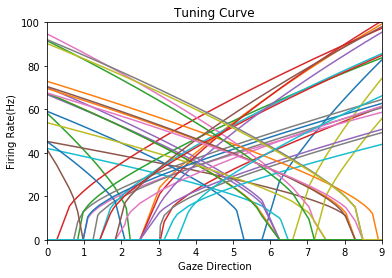

In [26]:
plt.axis([0., 9.0, 0., 100.0])

for i in range(40):
    plt.plot(X,A[:,i])
plt.title("Tuning Curve")
plt.xlabel("Gaze Direction")
plt.ylabel("Firing Rate(Hz)")
plt.show()

## (c) Compute the Decoding Weights

In [27]:
from numpy.linalg import inv
D = np.dot(np.dot(inv(np.dot(A.T,A)),A.T),X)

## (d) View Spike Raster of Unknown Sequence

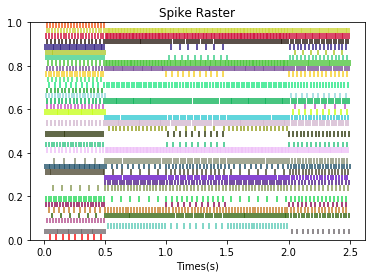

In [28]:
lif.PlotSpikeRaster(Asp)
plt.title("Spike Raster")
plt.xlabel("Times(s)")
plt.show()

## (e) Decode the Unknown Code

In [29]:
# Spike trains for unknown sequence are stored in 'Asp'
# Asp is a list of arrays of spike trains, one array per neuron.

sr1 = lif.CountSpikes(Asp,0,0.5)*2
sr2 = lif.CountSpikes(Asp,0.5,1)*2
sr3 = lif.CountSpikes(Asp,1,1.5)*2
sr4 = lif.CountSpikes(Asp,1.5,2)*2
sr5 = lif.CountSpikes(Asp,2,2.5)*2
D = D.reshape(40,1)
gaze_dir1 = round((sr1@D)[0])
gaze_dir2 = round((sr2@D)[0])
gaze_dir3 = round((sr3@D)[0])
gaze_dir4 = round((sr4@D)[0])
gaze_dir5 = round((sr5@D)[0])
print("0-0.5s gazing at " + str(gaze_dir1))
print("0.5-1s gazing at " + str(gaze_dir2))
print("1-1.5s gazing at " + str(gaze_dir3))
print("1.5-2s gazing at " + str(gaze_dir4))
print("2-2.5s gazing at " + str(gaze_dir5))


0-0.5s gazing at 8.0
0.5-1s gazing at 1.0
1-1.5s gazing at 4.0
1.5-2s gazing at -0.0
2-2.5s gazing at 4.0


In [30]:
# Compute firing rates

# ***** YOUR CODE HERE *****

## (f) Display the Unknown Code

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


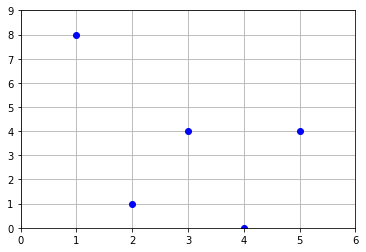

In [31]:
plt.axis([0,6,0,9])
plt.grid('on')
plt.plot(np.array([1,2,3,4,5]), np.array([gaze_dir1, gaze_dir2, gaze_dir3, gaze_dir4, gaze_dir5]), 'bo')
plt.show()

# Q2: LSTM

In [32]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

## (a)

### (i)

In [33]:
Wf = np.array([0, 8, 0, 0])
Wi = np.array([0, 0, 9, 0])
Wo = np.array([0, 0, 0, 10])
Wc = np.array([1, 0, 0, 0])
bf = np.array([-4])
bi = np.array([-4.5])
bo = np.array([-5])
bc = np.array([0])
h0 = np.array([0.05])
c0 = np.array([-0.02])

xt = np.array([1, 0, 0])

vt = np.array([0.05, 1.0, 0.,0.])
ft = sigmoid(Wf@vt + bf)
it = sigmoid(Wi@vt + bi)
ot = sigmoid(Wo@vt + bo)
ct_tilda = np.tanh(Wc@vt + bc)
ct = ft*c0 + it*ct_tilda
ht = ot*np.tanh(ct)

print("ct-1="+str(c0[0])+"  ht-1="+str(h0[0])+"  xt="+str(xt))
print("(ft, it, ot) = ("+str(ft[0])+", "+str(it[0])+", "+str(ot[0])+")")
print("ct_tilda= " + str(ct_tilda[0]))
print("ct="+str(ct[0])+"  ht="+str(ht[0]))
print("ct/ct-1 = " + str(ct[0]/c0[0]))
print("ht/ht-1 = " + str(ht[0]/h0[0]))

ct-1=-0.02  ht-1=0.05  xt=[1 0 0]
(ft, it, ot) = (0.9820137900379085, 0.01098694263059318, 0.0066928509242848554)
ct_tilda= 0.04995837495787998
ct=-0.01909138600117828  ht=-0.00012776027875546997
ct/ct-1 = 0.954569300058914
ht/ht-1 = -0.0025552055751093994


$$
\begin{equation}
when\ x_t = (1,0,0):\\
(f_t,i_t,o_t) \approx (1,0,0)=x_t\\
c_t \approx 1 * c_{t-1} + 0*\overset{\sim}{c_t}=-0.02\\
h_t \approx 0 * tanh(c_{t})=0\\
\end{equation}
$$

### (ii)

In [34]:
xt = np.array([0,1,0])
vt = np.array([0.05, 0., 1.0, 0.])
ft = sigmoid(Wf@vt + bf)
it = sigmoid(Wi@vt + bi)
ot = sigmoid(Wo@vt + bo)
ct_tilda = np.tanh(Wc@vt + bc)
ct = ft*c0 + it*ct_tilda
ht = ot*np.tanh(ct)

print("ct-1="+str(c0[0])+"  ht-1="+str(h0[0])+"  xt="+str(xt))
print("(ft, it, ot) = ("+str(ft[0])+", "+str(it[0])+", "+str(ot[0])+")")
print("ct_tilda= " + str(ct_tilda[0]))
print("ct="+str(ct[0])+"  ht="+str(ht[0]))
print("ct/ct-1 = " + str(ct[0]/c0[0]))
print("ct/ct_tilda = " + str(ct[0]/ct_tilda[0]))
print("ht/ht-1 = " + str(ht[0]/h0[0]))

ct-1=-0.02  ht-1=0.05  xt=[0 1 0]
(ft, it, ot) = (0.01798620996209156, 0.9890130573694068, 0.0066928509242848554)
ct_tilda= 0.04995837495787998
ct=0.049049760959058254  ht=0.00032801972156155
ct/ct-1 = -2.4524880479529125
ct/ct_tilda = 0.9818125789802455
ht/ht-1 = 0.006560394431231


$$
\begin{equation}
when\ x_t = (0,1,0):\\
(f_t,i_t,o_t) \approx (0,1,0)=x_t\\
c_t \approx 0*c_{t-1} + 1*\overset{\sim}{c_t}=0.05\\
h_t \approx 0*tanh(c_{t})=0\\
\end{equation}
$$

### (iii)

In [35]:
xt = np.array([1,0,1])
vt = np.array([0.05, 1.0, 0., 1.0])
ft = sigmoid(Wf@vt + bf)
it = sigmoid(Wi@vt + bi)
ot = sigmoid(Wo@vt + bo)
ct_tilda = np.tanh(Wc@vt + bc)
ct = ft*c0 + it*ct_tilda
ht = ot*np.tanh(ct)

print("ct-1="+str(c0[0])+"  ht-1="+str(h0[0])+"  xt="+str(xt))
print("(ft, it, ot) = ("+str(ft[0])+", "+str(it[0])+", "+str(ot[0])+")")
print("ct_tilda= " + str(ct_tilda[0]))
print("ct="+str(ct[0])+"  ht="+str(ht[0]))
print("ct/ct-1 = " + str(ct[0]/c0[0]))
print("ct/ct_tilda = " + str(ct[0]/ct_tilda[0]))
print("ht/ht-1 = " + str(ht[0]/h0[0]))

ct-1=-0.02  ht-1=0.05  xt=[1 0 1]
(ft, it, ot) = (0.9820137900379085, 0.01098694263059318, 0.9933071490757153)
ct_tilda= 0.04995837495787998
ct=-0.01909138600117828  ht=-0.018961306577925104
ct/ct-1 = 0.954569300058914
ct/ct_tilda = -0.3821458567712475
ht/ht-1 = -0.37922613155850204


$$
\begin{equation}
when\ x_t = (1,0,1):\\
(f_t,i_t,o_t) \approx (1,0,1)=x_t\\
c_t \approx 1*c_{t-1} + 0*\overset{\sim}{c_t}=-0.02\\
h_t \approx 1*tanh(c_{t})\approx -0.02\\
\end{equation}
$$

## (b)

In [36]:
xt = np.array([1,1,0])
vt = np.array([0.05, 1.0, 1.0, 0.])
ft = sigmoid(Wf@vt + bf)
it = sigmoid(Wi@vt + bi)
ot = sigmoid(Wo@vt + bo)
ct_tilda = np.tanh(Wc@vt + bc)
ct = ft*c0 + it*ct_tilda
ht = ot*np.tanh(ct)

print("ct-1="+str(c0[0])+"  ht-1="+str(h0[0])+"  xt="+str(xt))
print("(ft, it, ot) = ("+str(ft[0])+", "+str(it[0])+", "+str(ot[0])+")")
print("ct_tilda= " + str(ct_tilda[0]))
print("ct="+str(ct[0])+"  ht="+str(ht[0]))

print('ct-1 + ht-1 = ' + str((c0 + h0)[0]))


ct-1=-0.02  ht-1=0.05  xt=[1 1 0]
(ft, it, ot) = (0.9820137900379085, 0.9890130573694068, 0.0066928509242848554)
ct_tilda= 0.04995837495787998
ct=0.029769209357541914  ht=0.00019918204507686518
ct-1 + ht-1 = 0.030000000000000002


To make $c_t \approx c_{t - 1} + h_{t - 1}$, first note that
$$
\begin{align}
c_t = f_t \odot c_{t - 1} + i_t \odot \overset{\sim}{c_t} \\
tanh(x)=\frac{e^x-e^{-x}}{e^{x}+e^{-x}}=\frac{e^{2x}-1}{e^{2x}+1}\\
Since\ when\ x\ is\ big\, : \frac{e^{2x}-1}{e^{2x}+1}\approx 1\\
By\ applying\ tanh(x)\approx x:\\
c_t \approx f_t \odot c_{t - 1} + i_t \odot \left( W_cv_t + b_c \right) \\
= f_t \odot c_{t-1} + i_t \odot h_{t-1}\\
Then\ all\ we\ need\ to\ do\ is\ to\ make\ f_t=1\ and\ i_t=1\\
\end{align}
$$
Then as we can see, xt=(1,1,0) works out.

## (c)

In [37]:
xt = np.array([0.5,0.5,1])
vt = np.array([0.05,0.5,0.5,1.0])
ft = sigmoid(Wf@vt + bf)
it = sigmoid(Wi@vt + bi)
ot = sigmoid(Wo@vt + bo)
ct_tilda = np.tanh(Wc@vt + bc)
ct = ft*c0 + it*ct_tilda
ht = ot*np.tanh(ct)

print("ct-1="+str(c0[0])+"  ht-1="+str(h0[0])+"  xt="+str(xt))
print("(ft, it, ot) = ("+str(ft[0])+", "+str(it[0])+", "+str(ot[0])+")")
print("ct_tilda= " + str(ct_tilda[0]))
print("ct="+str(ct[0])+"  ht="+str(ht[0]))

print('(ct-1 + ht-1)/2 = ' + str((c0 + h0)[0]/2))
print("ct="+str(ct[0])+"  ht="+str(ht[0]))

ct-1=-0.02  ht-1=0.05  xt=[0.5 0.5 1. ]
(ft, it, ot) = (0.5, 0.5, 0.9933071490757153)
ct_tilda= 0.04995837495787998
ct=0.014979187478939988  ht=0.014877821284526208
(ct-1 + ht-1)/2 = 0.015000000000000001
ct=0.014979187478939988  ht=0.014877821284526208


$$
\begin{equation}
To\ make\ h_t=\frac{1}{2} (c_{t-1}+h_{t-1})\\
From\ h_t = o_t \odot \tanh(c_t) \\
\approx o_t \odot c_t \\
= o_t \odot \left( f_t \times c_{t - 1} + i_t \odot \overset{\sim}{c_t} \right) \\
= o_t \odot \Big( f_t \odot c_{t - 1} + i_t \odot \tanh\big(W_cv_t + b_c\big) \Big) \\
\approx o_t \odot \Big( f_t \odot c_{t - 1} + i_t \odot \big(W_cv_t + b_c \big) \Big) \\
= o_t f_t \odot c_{t - 1} + o_t i_t \odot h_{t - 1}\\
So\ we\ try\ to\ make\ f_t = \frac{1}{2}, i_t = \frac{1}{2}, o_t = 1\\
\end{equation}
$$

# Q3: Adversarial Inputs

## Load data, get trained network, etc.

In [38]:
# Load MNIST
train, validate, test = mnist_loader.load_data_wrapper()
train_in = np.array(train[0])
train_out = np.array(train[1])

In [39]:
# Or, you can load the pretrained Network object from the supplied file,
# like this...
net = NN.Network()
net.Load('MNIST_trained_784-100-100-10.npy')

In [40]:
test_ac = NN.ClassificationAccuracy(net.FeedForward(test[0]), test[1])
print('Testing Accuracy = '+str(test_ac*100)+'%')

train_ac = NN.ClassificationAccuracy(net.FeedForward(train[0]), train[1])
print('Training Accuracy = '+str(train_ac*100)+'%')

Testing Accuracy = 97.53%
Training Accuracy = 99.136%


In [41]:
#Extract 10 digits from MNIST classified correctly by the network
x_image = []
x_class = []
for i in range(0, 10):
    while True:
        j = random.randint(0, len(test[0]))
        if np.argmax(test[1][j]) == i:
            r = net.FeedForward([test[0][j]])
            if np.argmax(r) == i:
                x_image.append(test[0][j])
                x_class.append(test[1][j])
                break

## (a) GradientInput

In [70]:
def GradientInput(net, x, t):
    '''
        dEdx = Input_Gradient_Ascent(net, x, t)

        Computes dEdx for a network given input x and target t.
        The cost function is specified by the network.

        Inputs:
          net is the neural network
          x is the input that you want to perturb
          t is the corresponding true target vector (one-hot)
        
        Output:
          dEdx is a vector the same shape as x
    '''

    # ***** YOUR CODE HERE *****
    t = np.array(t)
    dEdx = copy.deepcopy(x)
    dEdz = net.TopGradient(t)
    result = net.W[0]
    
    for i in range(net.n_layers-2,0,-1):
        pre = net.lyr[i]
        dEdz = dEdz@net.W[i].T*pre.sigma_z_p(pre.z)
    dEdx = dEdz@result.T
    return dEdx

## (b) FGSM

In [90]:
def FGSM(net, x_input, x_class, ep=0.05, it_lim=100000, conf=0.5, targ=False):
    '''
        x_adv = FGSM(x_input, x_class, ep=0.05, it_lim=100000, conf=0.5)
        
        Performs the Fast Gradient Sign Method, perturbing each input until it
        is misclassified with the specified confidence, or reaches the maximum
        number of iterations.
        
        Inputs:
          x_input is a batch of inputs
          x_class is the corresponding one-hot class vectors
          ep is the perturbation step for the FGSM
          it_lim is the maximum number of iterations
          conf is the desired confidence for the misclassification
          targ is Boolean, indicating if the FGSM is targetted
             if targ is False, then x_class is considered to be the true
             class of the input, and FGSM will work to increase the cost
             if targ is True, then x_class is considered to be the target
             class for the perturbation, and FGSM will work to decrease the cost
        
        Output:
          x_adv is a batch of adversarial inputs, the same size as x_input
    '''

    # ***** YOUR CODE HERE *****
    target_class = np.argmax(x_class)
    x_adv = copy.deepcopy(x_input)
    
    current_confidence = 0

    if(targ == False):
        for i in range(it_lim):
            dEdx = GradientInput(net,x_adv,x_class)
            x_adv += ep*np.sign(dEdx)
            last_layer = net.FeedForward(x_adv)
            current_confidence = 1-last_layer[0][target_class]
            for x, p in zip(x_class, last_layer):
                print ("{} is classified as {}, classification value {}".format(np.argmax(x), np.argmax(p), p[np.argmax(p)]))
            if(current_confidence >= conf):
                break
    if(targ == True):
        for i in range(it_lim):
            dEdx = GradientInput(net,x_adv,x_class)
            x_adv -= ep*np.sign(dEdx)
            last_layer = net.FeedForward(x_adv)
            current_confidence = last_layer[0][target_class]
            print("current_confidence" + str(current_confidence))
            for x, p in zip(x_class, last_layer):
                print ("{} is classified as {}, classification value {}".format(np.argmax(x), np.argmax(p), p[np.argmax(p)]))
            if(current_confidence >= conf):
                break
    return np.array(x_adv)

## (c) Untargetted Adversarial Perturbation

0 is classified as 0, classification value 0.97914477033012
1 is classified as 1, classification value 0.994352960383299
2 is classified as 2, classification value 0.9998083152672633
3 is classified as 3, classification value 0.9823089598020184
4 is classified as 4, classification value 0.9970543278450859
5 is classified as 5, classification value 0.999708755390627
6 is classified as 6, classification value 0.9969408353351596
7 is classified as 7, classification value 0.9955776099246092
8 is classified as 8, classification value 0.9927328393630511
9 is classified as 9, classification value 0.9447873388648452
0 is classified as 0, classification value 0.975979409310644
1 is classified as 1, classification value 0.9928592358068543
2 is classified as 2, classification value 0.999781524700928
3 is classified as 3, classification value 0.9755165339077005
4 is classified as 4, classification value 0.9962312602000397
5 is classified as 5, classification value 0.9996381500212006
6 is classifie

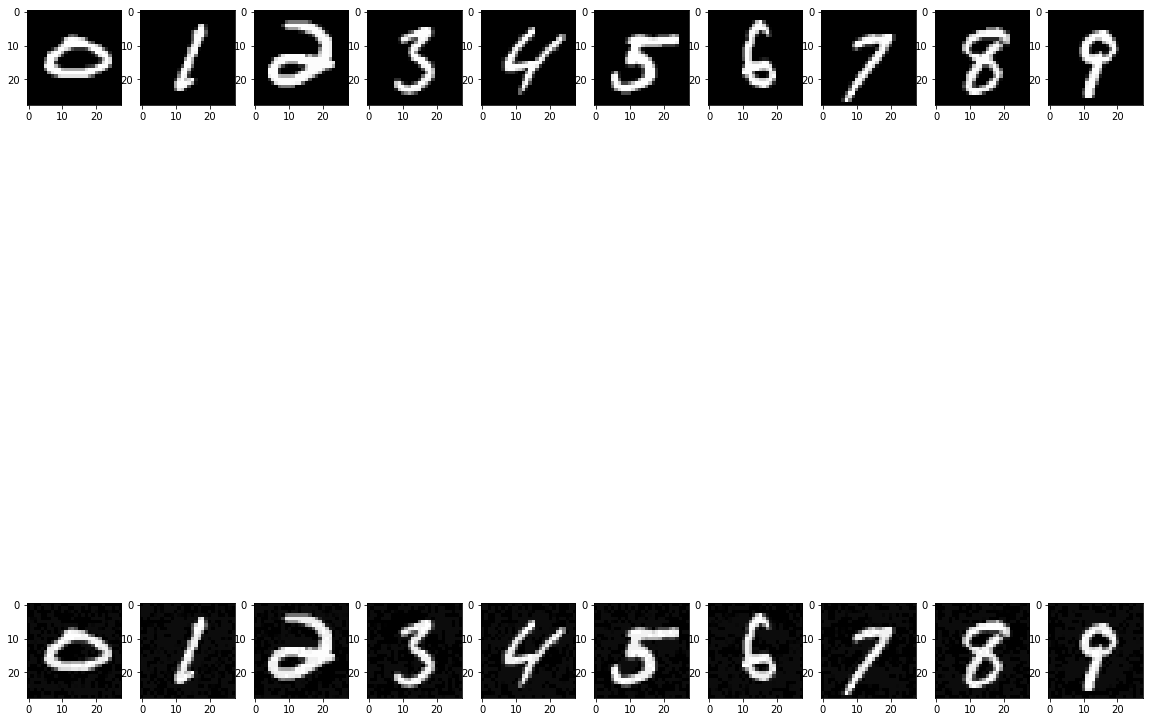

In [97]:
# ***** YOUR CODE HERE *****
x_adv = FGSM(net,x_image,x_class,ep=0.001)
plot = plt.figure(figsize=(20, 20))
for i in range(10):
    image1 = np.array(x_image[i]).reshape(28,28)
    plot.add_subplot(2,10,i+1)
    plt.imshow(image1,cmap='gray')
    
    plot.add_subplot(2,10,i+11)
    image2 = np.array(x_adv[i]).reshape(28,28)
    plt.imshow(image2,cmap='gray')


## (d) Targetted Adversarial Perturbation

In [101]:
# ***** YOUR CODE HERE *****
want_class = np.zeros([3,10])
want_class[0,3] = 1
want_class[1,0] = 1
want_class[2,6] = 1
print (want_class)
input_image = np.zeros([3,784])
input_image[0] = x_image[5]
input_image[1] = x_image[1]
input_image[2] = x_image[7]
x_adjust = FGSM(net, input_image,want_class,ep=0.01, conf=0.8, targ=True)
plt.clf()
fig = plt.figure(figsize=(12, 13))
plt.subplots_adjust(hspace=0.1,wspace=0.3)
for idx in range(3):
    im = np.array(x_adjust[idx])
    im = im.reshape(28,28)
    plotwindow = fig.add_subplot(1,3,idx + 1)
    plt.imshow(im , cmap='gray')

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


ValueError: operands could not be broadcast together with shapes (10,10) (3,10) 